In [ ]:
from os import listdir
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator

Using TensorFlow backend.


In [ ]:
from googleapiclient.discovery import build
import io, os
from googleapiclient.http import MediaIoBaseDownload
from google.colab import auth
auth.authenticate_user()
drive_service = build('drive', 'v3')
results = drive_service.files().list(
        q="name = 'kaggle.json'", fields="files(id)").execute()
kaggle_api_key = results.get('files', [])
filename = "/content/.kaggle/kaggle.json"
os.makedirs(os.path.dirname(filename), exist_ok=True)
request = drive_service.files().get_media(fileId=kaggle_api_key[0]['id'])
fh = io.FileIO(filename, 'wb')
downloader = MediaIoBaseDownload(fh, request)
done = False
while done is False:
    status, done = downloader.next_chunk()
    print("Download %d%%." % int(status.progress() * 100))
os.chmod(filename, 600)


Download 100%.


In [ ]:
from google.colab import drive,files
drive.mount('/gdrive')
DATA_PATH = '/gdrive'


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /gdrive


In [ ]:
!mkdir ~/.kaggle

!kaggle competitions download -c dogs-vs-cats-redux-kernels-edition
#!kaggle competitions download  -c dogs-vs-cats-redux -p /content/kaggle

mkdir: cannot create directory ‘/root/.kaggle’: File exists
test.zip: Skipping, found more recently modified local copy (use --force to force download)
train.zip: Skipping, found more recently modified local copy (use --force to force download)
sample_submission.csv: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:

!unzip train.zip 
!unzip test.zip 

In [ ]:
! ls

adc.json  sample_data  sample_submission.csv  test  test.zip  train  train.zip


In [ ]:
train='train'
label = []
for file in listdir(train):
  category = file.split('.')[0]
  if category=='dog':
    label.append('dog')
  if category == 'cat' :
    label.append("cat")

df = pd.DataFrame()
df['filename']=listdir(train)
df['label']=label

df.head()

,filename,label
0,dog.8619.jpg,dog
1,cat.9987.jpg,cat
2,dog.1018.jpg,dog
3,dog.1678.jpg,dog
4,cat.2263.jpg,cat


In [ ]:
x_train,x_test= train_test_split(df,test_size = 0.3,random_state = 12)
x_train=x_train.reset_index()
x_test=x_test.reset_index()

In [ ]:
x_train.head()

,index,filename,label
0,11710,dog.337.jpg,dog
1,6496,cat.572.jpg,cat
2,13873,dog.2767.jpg,dog
3,21132,cat.11331.jpg,cat
4,4655,cat.8381.jpg,cat


In [ ]:
image_size =224
train_datagen = ImageDataGenerator(rescale = 1./255,
                                         rotation_range=15,
     shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    width_shift_range=0.1,
    height_shift_range=0.1)
train_generator = train_datagen.flow_from_dataframe(x_train,
                                train,
                                x_col = "filename",
                                y_col = "label",
                                class_mode = 'binary',
                                target_size = (image_size,image_size),
                                batch_size=16
                                )

Found 17500 validated image filenames belonging to 2 classes.


0.0


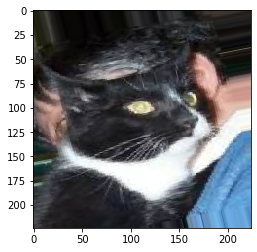

In [ ]:
for i,j in train_generator:
  plt.imshow(i[2])
  print(j[2])
  break



In [ ]:
image_size =224
validation_datagen = ImageDataGenerator(rescale = 1./255,
                                         rotation_range=15,
     shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    width_shift_range=0.1,
    height_shift_range=0.1)
validation_generator = validation_datagen.flow_from_dataframe(x_test,
                                train,
                                x_col = "filename",
                                y_col = "label",
                                class_mode = 'binary',
                                target_size = (image_size,image_size),
                                batch_size=16)

Found 7500 validated image filenames belonging to 2 classes.


Model 1 :  ResNet50

In [ ]:
from keras.applications import ResNet50,VGG16
import keras.optimizers
from keras.models import Model,Sequential
from keras import optimizers
from keras import layers
from keras.layers import GlobalMaxPooling2D,Dense,Dropout

In [ ]:
base_model = ResNet50(weights='imagenet',include_top=False,input_shape = (224,224,3))
for layer in base_model.layers[:48]:
  layer.trainable = False
for layer in base_model.layers[48:]:
  layer.trainable = True
#base_model.layers[-1].ouput
last = base_model.layers[-1]
X = GlobalMaxPooling2D()(last.output)
X = Dense(512, activation ='relu')(X)
X = Dropout(0.2)(X)
X = Dense(1, activation = 'sigmoid')(X)

model = Model(base_model.input, X)

model.compile(loss = 'binary_crossentropy',
              optimizer = optimizers.SGD(lr=1e-4, momentum = 0.9),
              metrics=['accuracy'])
model.summary()

/usr/local/lib/python3.6/dist-packages/keras_applications/resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


94658560/94653016 [==============================] - 3s 0us/step

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
_____________

In [ ]:
#model.fit_generator(train_generator,)
batch_size=16
history = model.fit_generator(
    train_generator,
    epochs=20,
    validation_data=validation_generator)#,
    #validation_steps=2500//batch_size)
    #steps_per_epoch=22500//batch_size)



Epoch 1/20
1407/1407 [==============================] - 324s 231ms/step - loss: 0.4868 - acc: 0.7495 - val_loss: 0.7185 - val_acc: 0.4912
Epoch 2/20
1407/1407 [==============================] - 311s 221ms/step - loss: 0.1398 - acc: 0.9510 - val_loss: 0.7253 - val_acc: 0.4912
Epoch 3/20
1407/1407 [==============================] - 311s 221ms/step - loss: 0.0942 - acc: 0.9669 - val_loss: 0.6940 - val_acc: 0.5052
Epoch 4/20
1407/1407 [==============================] - 312s 221ms/step - loss: 0.0774 - acc: 0.9733 - val_loss: 0.7441 - val_acc: 0.4916
Epoch 5/20
1407/1407 [==============================] - 310s 221ms/step - loss: 0.0707 - acc: 0.9761 - val_loss: 0.7041 - val_acc: 0.4952
Epoch 6/20
1407/1407 [==============================] - 311s 221ms/step - loss: 0.0624 - acc: 0.9798 - val_loss: 0.8189 - val_acc: 0.4916
Epoch 7/20
1407/1407 [==============================] - 311s 221ms/step - loss: 0.0564 - acc: 0.9804 - val_loss: 0.7916 - val_acc: 0.5088
Epoch 8/20
1407/1407 [==========

Model 2 : VGG16


In [ ]:
image_size = 224
input_shape = (image_size, image_size, 3)

epochs = 5
batch_size = 16

pre_trained_model = VGG16(input_shape=input_shape, include_top=False, weights='imagenet')
    
#for layer in pre_trained_model.layers[:1]:
#    layer.trainable = False

#for layer in pre_trained_model.layers[1:]:
#    layer.trainable = True
    
#last_layer = pre_trained_model.get_layer('block5_pool')
#last_output = last_layer.output
    
# Flatten the output layer to 1 dimension
#x = GlobalMaxPooling2D()(last_output)
# Add a fully connected layer with 512 hidden units and ReLU activation
#x = Dense(512, activation='relu')(x)
# Add a dropout rate of 0.5
#x = Dropout(0.5)(x)
# Add a final sigmoid layer for classification
#x = Dense(1, activation='sigmoid')(x)
#model2 = Model(pre_trained_model.input, x)
########################################



model2 = Sequential()
model2.add(pre_trained_model)
model2.add(layers.Flatten())
model2.add(layers.Dropout(0.5))
model2.add(layers.Dense(256, activation='relu'))
model2.add(layers.Dense(1, activation='sigmoid'))
#########################################
pre_trained_model.trainable = True


model2.compile(loss='binary_crossentropy',
              optimizer=optimizers.SGD(lr=1e-4, momentum=0.9),
              metrics=['accuracy'])

model2.summary()



Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten_2 (Flatten)          (None, 25088)             0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 25088)             0         
_________________________________________________________________
dense_3 (Dense)              (None, 256)               6422784   
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 257       
Total params: 21,137,729
Trainable params: 21,137,729
Non-trainable params: 0
_________________________________________________________________


In [ ]:
#model.fit_generator(train_generator,)
batch_size=16
history = model2.fit_generator(
    train_generator,
    epochs=3,
    validation_data=validation_generator,
    validation_steps=7500//batch_size,
    steps_per_epoch=17500//batch_size)



Epoch 1/3
1093/1093 [==============================] - 648s 593ms/step - loss: 0.2351 - acc: 0.8894 - val_loss: 0.0885 - val_acc: 0.9643
Epoch 2/3
1093/1093 [==============================] - 644s 589ms/step - loss: 0.0888 - acc: 0.9647 - val_loss: 0.1002 - val_acc: 0.9579
Epoch 3/3
1093/1093 [==============================] - 638s 584ms/step - loss: 0.0679 - acc: 0.9728 - val_loss: 0.0559 - val_acc: 0.9768


In [ ]:
test='test'
id = []
for file in listdir(test):
  category = file.split('.')[0]
  id.append(category)
  

final_test = pd.DataFrame()
#final_test['id']=id
final_test['name']=listdir(test)

final_test.head()

,name
0,2404.jpg
1,1552.jpg
2,10095.jpg
3,4902.jpg
4,7722.jpg


In [ ]:
image_size =224
final_test_datagen = ImageDataGenerator(rescale = 1./255 ,              rotation_range=15,
     shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    width_shift_range=0.1,
    height_shift_range=0.1)

final_test_generator = final_test_datagen.flow_from_dataframe(final_test,
                                'test',
                                x_col = "name",
                                y_col=None,
                                class_mode=None,
                                target_size = (image_size,image_size),
                                batch_size=16)

Found 12500 validated image filenames.


In [ ]:
import numpy as np
nb_samples = final_test.shape[0]

predict = model2.predict_generator(final_test_generator, steps=np.ceil(nb_samples/batch_size))
#threshold = 0.5
#final_test['category'] = np.where(predict > threshold, 1,0)


In [ ]:
final_test['category']=predict
final_test.shape

(12500, 2)

In [ ]:

submission_df = final_test.copy()
submission_df['id'] = submission_df['name'].str.split('.').str[0]
submission_df['label'] = submission_df['category']
submission_df['label']=np.clip(submission_df['label'],0.04,0.96)
submission_df.drop(['name', 'category'], axis=1, inplace=True)
submission_df.to_csv('submissionnov24-21.csv', index=False)


The best accuracy I achieved is 97% with VGG16. The score on kaggle i was able to achieve was 0.9.